In [1]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using LinearAlgebra
using Random

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.
┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1278
┌ Warning: Package GraphPPL does not have ReactiveMP in its dependencies:
│ - If you have GraphPPL checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GraphPPL
└ Loading ReactiveMP into GraphPPL from project dependency, future 

In [49]:
@model function rotate_ssm(n, θ, x0, Q, P)
    
    x = randomvar(n)
    y = datavar(Vector{Float64}, n)
    
    x_prior ~ MvNormalMeanCovariance(mean(x0), cov(x0))
    
    x_prev = x_prior
    
    A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
    
    for i in 1:n
        x[i] ~ MvNormalMeanCovariance(A * x_prev, Q) where { q = q(out, mean)q(cov) }
        y[i] ~ MvNormalMeanCovariance(x[i], P) where { q = q(out)q(mean)q(cov) }
        
        x_prev = x[i]
    end
    
    return x, y
end

rotate_ssm (generic function with 1 method)

In [198]:
Random.seed!(1234)

θ = π / 10
A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
Q = Matrix(Diagonal(1.0 * ones(2)))
P = Matrix(Diagonal(1.0 * ones(2)))

n = 325

x_prev = [ 10.0, -10.0 ]

x = Vector{Vector{Float64}}(undef, n)
y = Vector{Vector{Float64}}(undef, n)

for i in 1:n
    x[i] = rand(MvNormal(A * x_prev, Q))
    y[i] = rand(MvNormal(x[i], Q))
    
    x_prev = x[i]
end

In [178]:
using Plots

In [179]:
slicedim(dim) = (a) -> map(e -> e[dim], a)

slicedim (generic function with 1 method)

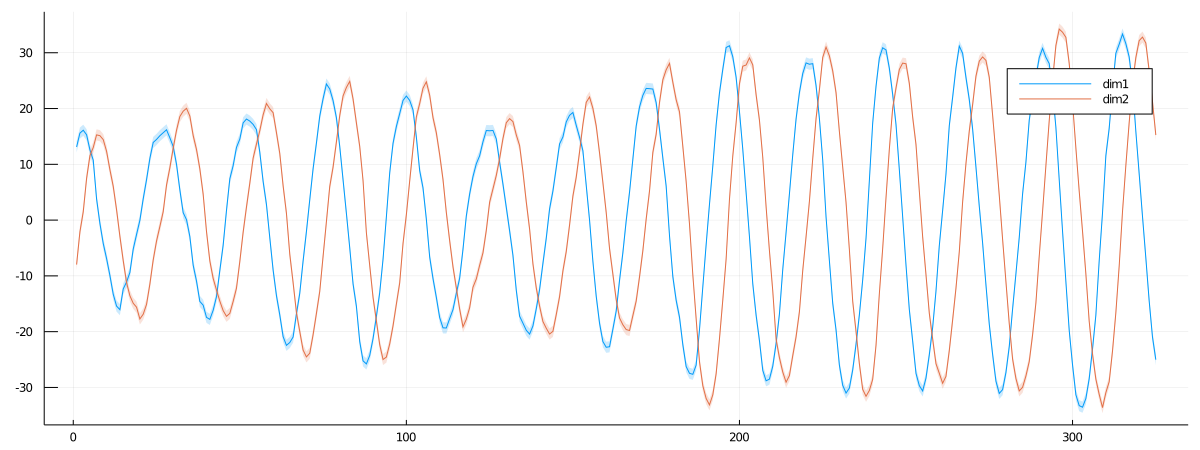

In [180]:
px = plot()

px = plot!(px, x |> slicedim(1), ribbon = diag(Q)[1] .|> sqrt, fillalpha = 0.2, label = :dim1)
px = plot!(px, x |> slicedim(2), ribbon = diag(Q)[2] .|> sqrt, fillalpha = 0.2, label = :dim2)

plot(px, size = (1200, 450))

In [199]:
function inference(observations, θ, x0)

    model, (x, y) = rotate_ssm(n, θ, x0, Q, P);

    ms_buffer = Vector{Marginal}(undef, n)
    fe_buffer = nothing
    
    marginals = collectLatest(getmarginals(x))

    fe_subscription = subscribe!(score(BetheFreeEnergy(), model, AsapScheduler()), (fe) -> fe_buffer = fe)
    ms_subscription = subscribe!(marginals, (ms) -> copyto!(ms_buffer, ms))
    
    update!(y, observations)

    unsubscribe!(ms_subscription)
    unsubscribe!(fe_subscription)
    
    return ms_buffer, fe_buffer
end

inference (generic function with 1 method)

In [200]:
function f(θ)
    x0 = MvNormalMeanCovariance([ θ[2], θ[3] ], Matrix(Diagonal(0.01 * ones(2))))
    xmarginals, fe = inference(y, θ[1], x0); 
    return fe
end

f (generic function with 1 method)

In [201]:
using Optim

In [202]:
res = optimize(f, zeros(3), LBFGS(), Optim.Options(f_tol = 1e-14, g_tol = 1e-12, show_trace = true))

Iter     Function value   Gradient norm 
     0     3.875561e+03     1.064403e+04
 * time: 0.0001761913299560547
     1     2.503070e+03     1.425223e+03
 * time: 14.011963129043579
     2     2.479280e+03     6.903758e+00
 * time: 15.31554913520813
     3     2.478971e+03     1.586860e+02
 * time: 19.797083139419556
     4     2.417418e+03     4.509102e+01
 * time: 23.846609115600586
     5     2.417393e+03     4.560835e-01
 * time: 25.834214210510254
     6     2.417393e+03     3.956632e-01
 * time: 28.57734203338623
     7     2.417350e+03     9.933325e-03
 * time: 31.95488405227661
     8     2.417350e+03     8.260686e-07
 * time: 34.01733899116516
     9     2.417350e+03     2.628400e-07
 * time: 35.41459012031555
    10     2.417350e+03     9.762629e-07
 * time: 36.765159130096436


 * Status: success

 * Candidate solution
    Final objective value:     2.417350e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 3.04e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.76e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.55e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.88e-16 ≤ 1.0e-14
    |g(x)|                 = 9.76e-07 ≰ 1.0e-12

 * Work counters
    Seconds run:   37  (vs limit Inf)
    Iterations:    10
    f(x) calls:    55
    ∇f(x) calls:   55


In [205]:
println("Real value vs Optimized")
println("Real:      ", θ)
println("Optimized: ", res.minimizer)

Real value vs Optimized
Real:      0.3141592653589793
Optimized: [0.25386161796494583, 11.014024159966684, -8.490518428401257]


In [206]:
@show sin(θ), sin(res.minimizer[1])
@show cos(θ), cos(res.minimizer[1])

(sin(θ), sin(res.minimizer[1])) = (0.3090169943749474, 0.25114367491639084)
(cos(θ), cos(res.minimizer[1])) = (0.9510565162951535, 0.9679498202641964)


(0.9510565162951535, 0.9679498202641964)

In [207]:
xmarginals, fe = inference(y, res.minimizer[1], MvNormalMeanCovariance([ res.minimizer[2], res.minimizer[3] ], Matrix(Diagonal(100.0 * ones(2)))));

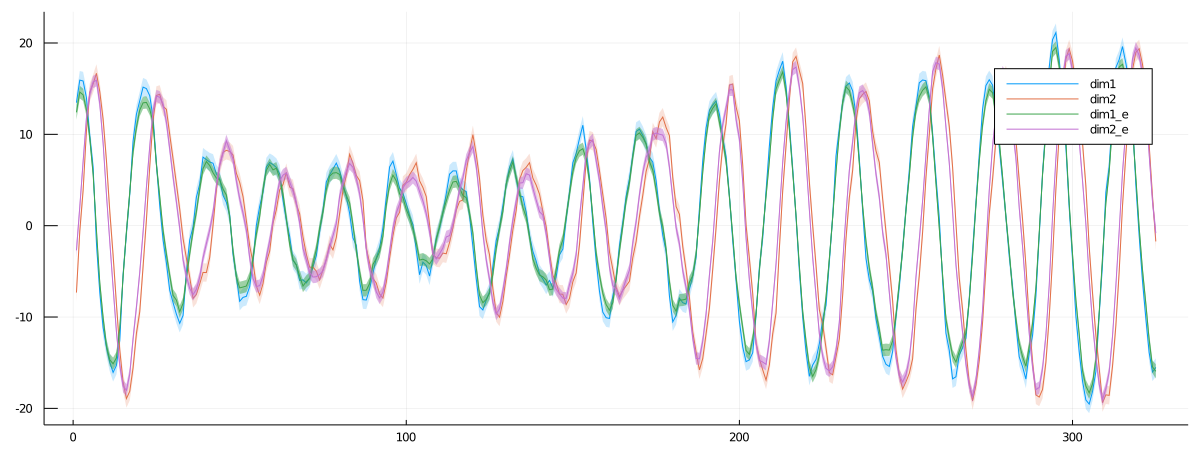

In [208]:
px = plot()

px = plot!(px, x |> slicedim(1), ribbon = diag(Q)[1] .|> sqrt, fillalpha = 0.2, label = :dim1)
px = plot!(px, x |> slicedim(2), ribbon = diag(Q)[2] .|> sqrt, fillalpha = 0.2, label = :dim2)
px = plot!(px, mean.(xmarginals) |> slicedim(1), ribbon = var.(xmarginals) |> slicedim(1) .|> sqrt, fillalpha = 0.5, label = :dim1_e)
px = plot!(px, mean.(xmarginals) |> slicedim(2), ribbon = var.(xmarginals) |> slicedim(2) .|> sqrt, fillalpha = 0.5, label = :dim2_e)

plot(px, size = (1200, 450))